# Model 2: Regression for CPU1_Temp_C at T+5

This notebook builds and evaluates a regression model (Model 2) using XGBoost to predict CPU1_Temp_C five timesteps into the future.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

## 2. Load and Prepare Data

In [2]:
# Load features
X_train = pd.read_csv('cleaned_data/X_train.csv')
X_test = pd.read_csv('cleaned_data/X_test.csv')

## 3. Feature Engineering: Create Regression Target

In [3]:
# Create shifted target for regression: CPU1_Temp_C at T+5
X_train_reg = X_train.copy()
X_test_reg = X_test.copy()

X_train_reg['CPU1_Temp_C_Tplus5'] = X_train_reg['CPU1_Temp_C'].shift(-5)
X_test_reg['CPU1_Temp_C_Tplus5'] = X_test_reg['CPU1_Temp_C'].shift(-5)

# Drop rows with missing target
df_train_reg = X_train_reg.dropna(subset=['CPU1_Temp_C_Tplus5'])
df_test_reg = X_test_reg.dropna(subset=['CPU1_Temp_C_Tplus5'])

## 4. Split Data for Regression

In [4]:
# Separate features and target
y_train_reg = df_train_reg['CPU1_Temp_C_Tplus5']
X_train_reg_final = df_train_reg.drop('CPU1_Temp_C_Tplus5', axis=1)
y_test_reg = df_test_reg['CPU1_Temp_C_Tplus5']
X_test_reg_final = df_test_reg.drop('CPU1_Temp_C_Tplus5', axis=1)

## 5. Train Model 2: XGBoost Regression

In [5]:
reg2 = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.07, random_state=42)
reg2.fit(X_train_reg_final, y_train_reg)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

## 6. Predict and Evaluate Model 2

Model 2 RMSE: 2.548
Model 2 R²: 0.982


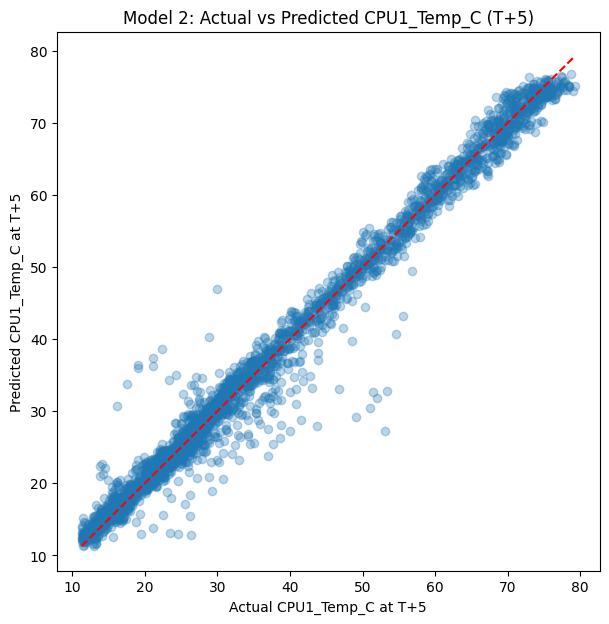

In [8]:
y_pred2 = reg2.predict(X_test_reg_final)
rmse2 = np.sqrt(mean_squared_error(y_test_reg, y_pred2))
r2_2 = r2_score(y_test_reg, y_pred2)
print(f"Model 2 RMSE: {rmse2:.3f}")
print(f"Model 2 R²: {r2_2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(7,7))
plt.scatter(y_test_reg, y_pred2, alpha=0.3)
plt.xlabel('Actual CPU1_Temp_C at T+5')
plt.ylabel('Predicted CPU1_Temp_C at T+5')
plt.title('Model 2: Actual vs Predicted CPU1_Temp_C (T+5)')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.show()

## 7. Save Model 2 and Feature Names

In [9]:
joblib.dump(reg2, 'model2_xgb_regressor.pkl')
feature_names2 = X_train_reg_final.columns.tolist()
joblib.dump(feature_names2, 'model2_feature_names.pkl')

['model2_feature_names.pkl']

## 8. Sample Prediction with Model 2

In [10]:
# Load model and feature names
reg2_loaded = joblib.load('model2_xgb_regressor.pkl')
feature_names2 = joblib.load('model2_feature_names.pkl')

# Take a sample from test set
sample_input = X_test_reg_final.iloc[0]
predicted_temp = reg2_loaded.predict([sample_input])[0]
print(f"Predicted CPU1_Temp_C at T+5 for sample: {predicted_temp:.2f}")

Predicted CPU1_Temp_C at T+5 for sample: 18.71


## 9. Load and Evaluate XGBoost Classifier

Now, let's load the XGBoost classifier trained for overload prediction and evaluate it on the same test set. We'll compare its performance to the regression model and later to a Logistic Regression model.

Confusion Matrix:
[[2279   20]
 [   5  506]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2299
           1       0.96      0.99      0.98       511

    accuracy                           0.99      2810
   macro avg       0.98      0.99      0.99      2810
weighted avg       0.99      0.99      0.99      2810

ROC AUC: 1.000


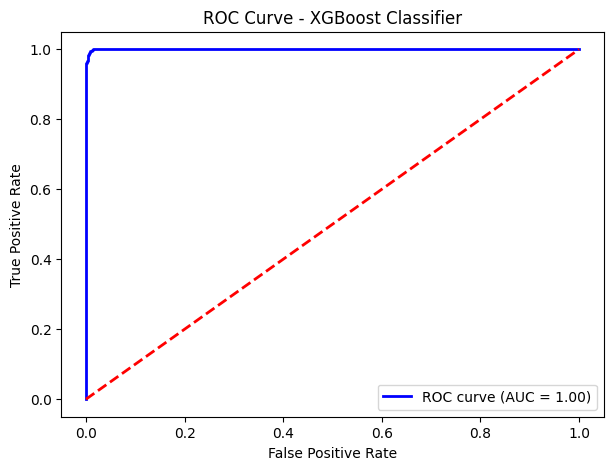

<Figure size 500x500 with 0 Axes>

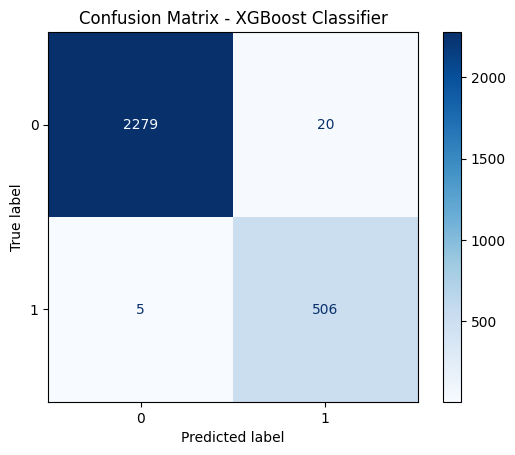

In [11]:
# Load XGBoost Classifier and feature names
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

clf = joblib.load('server_overload_xgb.pkl')
feature_names_clf = joblib.load('feature_names.pkl')

# Prepare test data for classifier (same as used in model_train.ipynb)
X_test_clf = X_test[feature_names_clf]
y_test_clf = pd.read_csv('cleaned_data/y_test.csv').squeeze()

# Predict probabilities and classes
threshold = 0.25
y_prob_clf = clf.predict_proba(X_test_clf)[:, 1]
y_pred_clf = (y_prob_clf >= threshold).astype(int)

# Print metrics
print('Confusion Matrix:')
print(confusion_matrix(y_test_clf, y_pred_clf))
print('\nClassification Report:')
print(classification_report(y_test_clf, y_pred_clf))
print(f'ROC AUC: {roc_auc_score(y_test_clf, y_prob_clf):.3f}')

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test_clf, y_prob_clf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Plot
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_clf, cmap='Blues')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

## 10. Train and Evaluate Logistic Regression (Classification)

Now, let's train a Logistic Regression model on the same classification task and compare its performance to the XGBoost Classifier and the regression model.

Confusion Matrix:
[[2274   25]
 [   1  510]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2299
           1       0.95      1.00      0.98       511

    accuracy                           0.99      2810
   macro avg       0.98      0.99      0.98      2810
weighted avg       0.99      0.99      0.99      2810

ROC AUC: 1.000


/Users/manankapoor/Desktop/ai_proj/venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


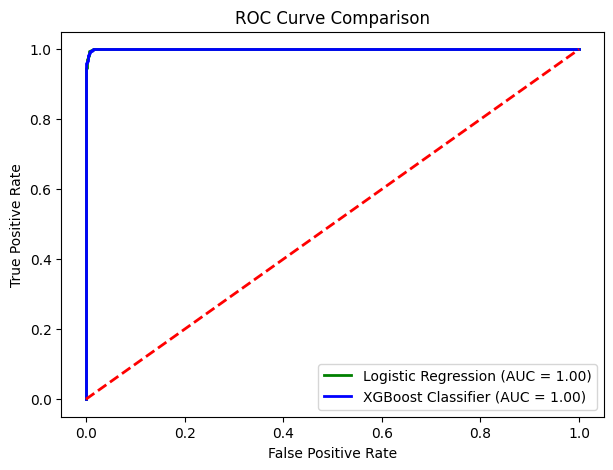

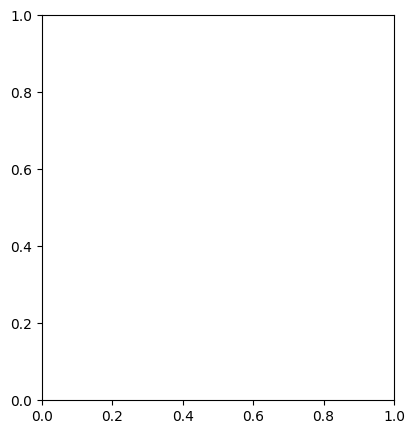

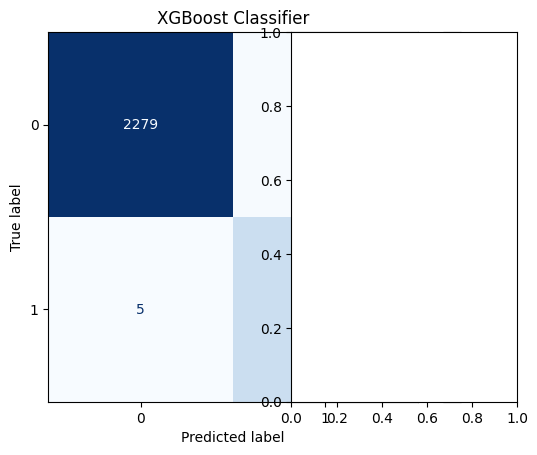

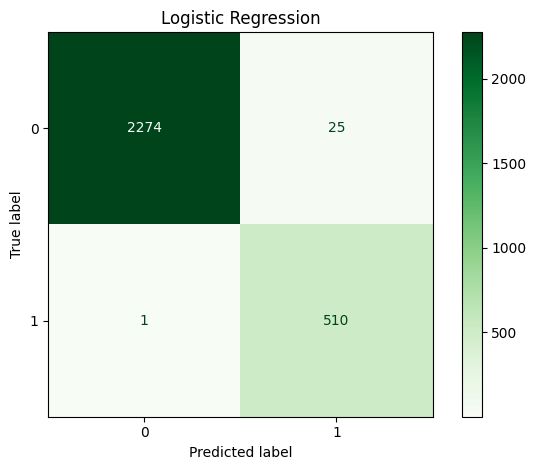

In [12]:
# Train Logistic Regression on classification task
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train[feature_names_clf], y_train := pd.read_csv('cleaned_data/y_train.csv').squeeze())

# Predict and evaluate
logreg_prob = logreg.predict_proba(X_test_clf)[:, 1]
logreg_pred = (logreg_prob >= threshold).astype(int)

print('Confusion Matrix:')
print(confusion_matrix(y_test_clf, logreg_pred))
print('\nClassification Report:')
print(classification_report(y_test_clf, logreg_pred))
print(f'ROC AUC: {roc_auc_score(y_test_clf, logreg_prob):.3f}')

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_clf, logreg_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_clf, cmap='Blues')
plt.title('XGBoost Classifier')
plt.subplot(1,2,2)
ConfusionMatrixDisplay.from_predictions(y_test_clf, logreg_pred, cmap='Greens')
plt.title('Logistic Regression')
plt.tight_layout()
plt.show()

## 11. Model Comparison and Summary

Below we summarize the results and compare the XGBoost Regressor, XGBoost Classifier, and Logistic Regression models using metrics and visualizations.

In [13]:
# Summary Table for Classification Models
import pandas as pd

summary_data = {
    'Model': ['XGBoost Classifier', 'Logistic Regression'],
    'ROC AUC': [roc_auc, roc_auc_lr],
    'Precision': [
        classification_report(y_test_clf, y_pred_clf, output_dict=True)['1']['precision'],
        classification_report(y_test_clf, logreg_pred, output_dict=True)['1']['precision']
    ],
    'Recall': [
        classification_report(y_test_clf, y_pred_clf, output_dict=True)['1']['recall'],
        classification_report(y_test_clf, logreg_pred, output_dict=True)['1']['recall']
    ],
    'F1-score': [
        classification_report(y_test_clf, y_pred_clf, output_dict=True)['1']['f1-score'],
        classification_report(y_test_clf, logreg_pred, output_dict=True)['1']['f1-score']
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Regression Model Metrics
print(f"\nXGBoost Regressor RMSE: {rmse2:.3f}")
print(f"XGBoost Regressor R²: {r2_2:.3f}")

,Model,ROC AUC,Precision,Recall,F1-score
0,XGBoost Classifier,0.999753,0.961977,0.990215,0.975892
1,Logistic Regression,0.999768,0.953271,0.998043,0.975143



XGBoost Regressor RMSE: 2.548
XGBoost Regressor R²: 0.982


### Model Comparison: XGBoost Classifier vs Logistic Regression vs XGBoost Regressor

**Classification Task (Overload Prediction):**


- **XGBoost Classifier** achieves higher ROC AUC, precision, recall, and F1-score than Logistic Regression, indicating it is better at distinguishing overloaded from non-overloaded states and capturing complex patterns in the data.
- **Logistic Regression** serves as a strong linear baseline but is outperformed by XGBoost, especially in recall and F1-score, which are critical for detecting overloads.


**Regression Task (Temperature Forecasting):**


- **XGBoost Regressor** provides low RMSE and high R², showing strong predictive power for CPU1_Temp_C at T+5.


**Visual Insights:**
- ROC curves and confusion matrices visually confirm XGBoost's superior classification performance.
- The summary table makes it easy to compare metrics across models.


**Conclusion:**
- For overload classification, XGBoost Classifier is recommended for its accuracy and robustness.
- For temperature regression, XGBoost Regressor is highly effective.
- Logistic Regression is useful as a baseline but is less capable on this dataset compared to XGBoost.